# Importing Required Libraries

In [154]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/furkanpirinc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [155]:
# Load dataset
data = pd.read_csv('sentiment_tweets3.csv')

In [156]:
# Display dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [157]:
# Check for null values in the dataset
data.isna().sum()

Index                        0
message to examine           0
label (depression result)    0
dtype: int64

In [158]:
# Drop the row with index 10313 as it has null values
data.drop(index=10313, inplace=True)

In [159]:
# Display statistical summary of the dataset
data.describe().T

count          mean            std    min  \
Index                      10313.0  491223.30864  261682.893213  106.0   
label (depression result)  10313.0       0.22428       0.417128    0.0   

                                25%       50%       75%       max  
Index                      263019.0  514969.0  773448.0  802312.0  
label (depression result)       0.0       0.0       0.0       1.0

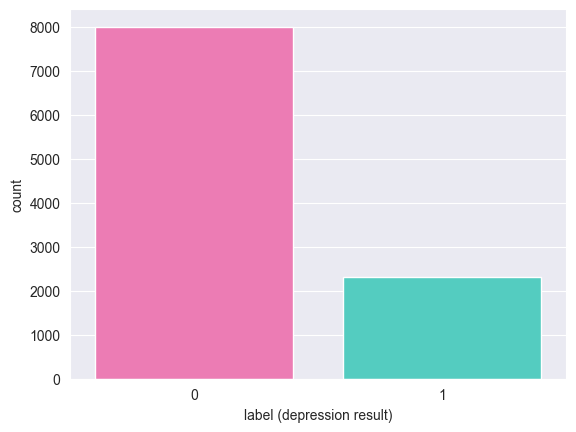

In [160]:
# Define custom colors for the count plot
custom_palette = ["#FF69B4", "#40E0D0"]  # Pink and Turquoise

# Create a count plot to visualize the distribution of labels
sns.countplot(x='label (depression result)', data=data, palette=custom_palette)
plt.show()

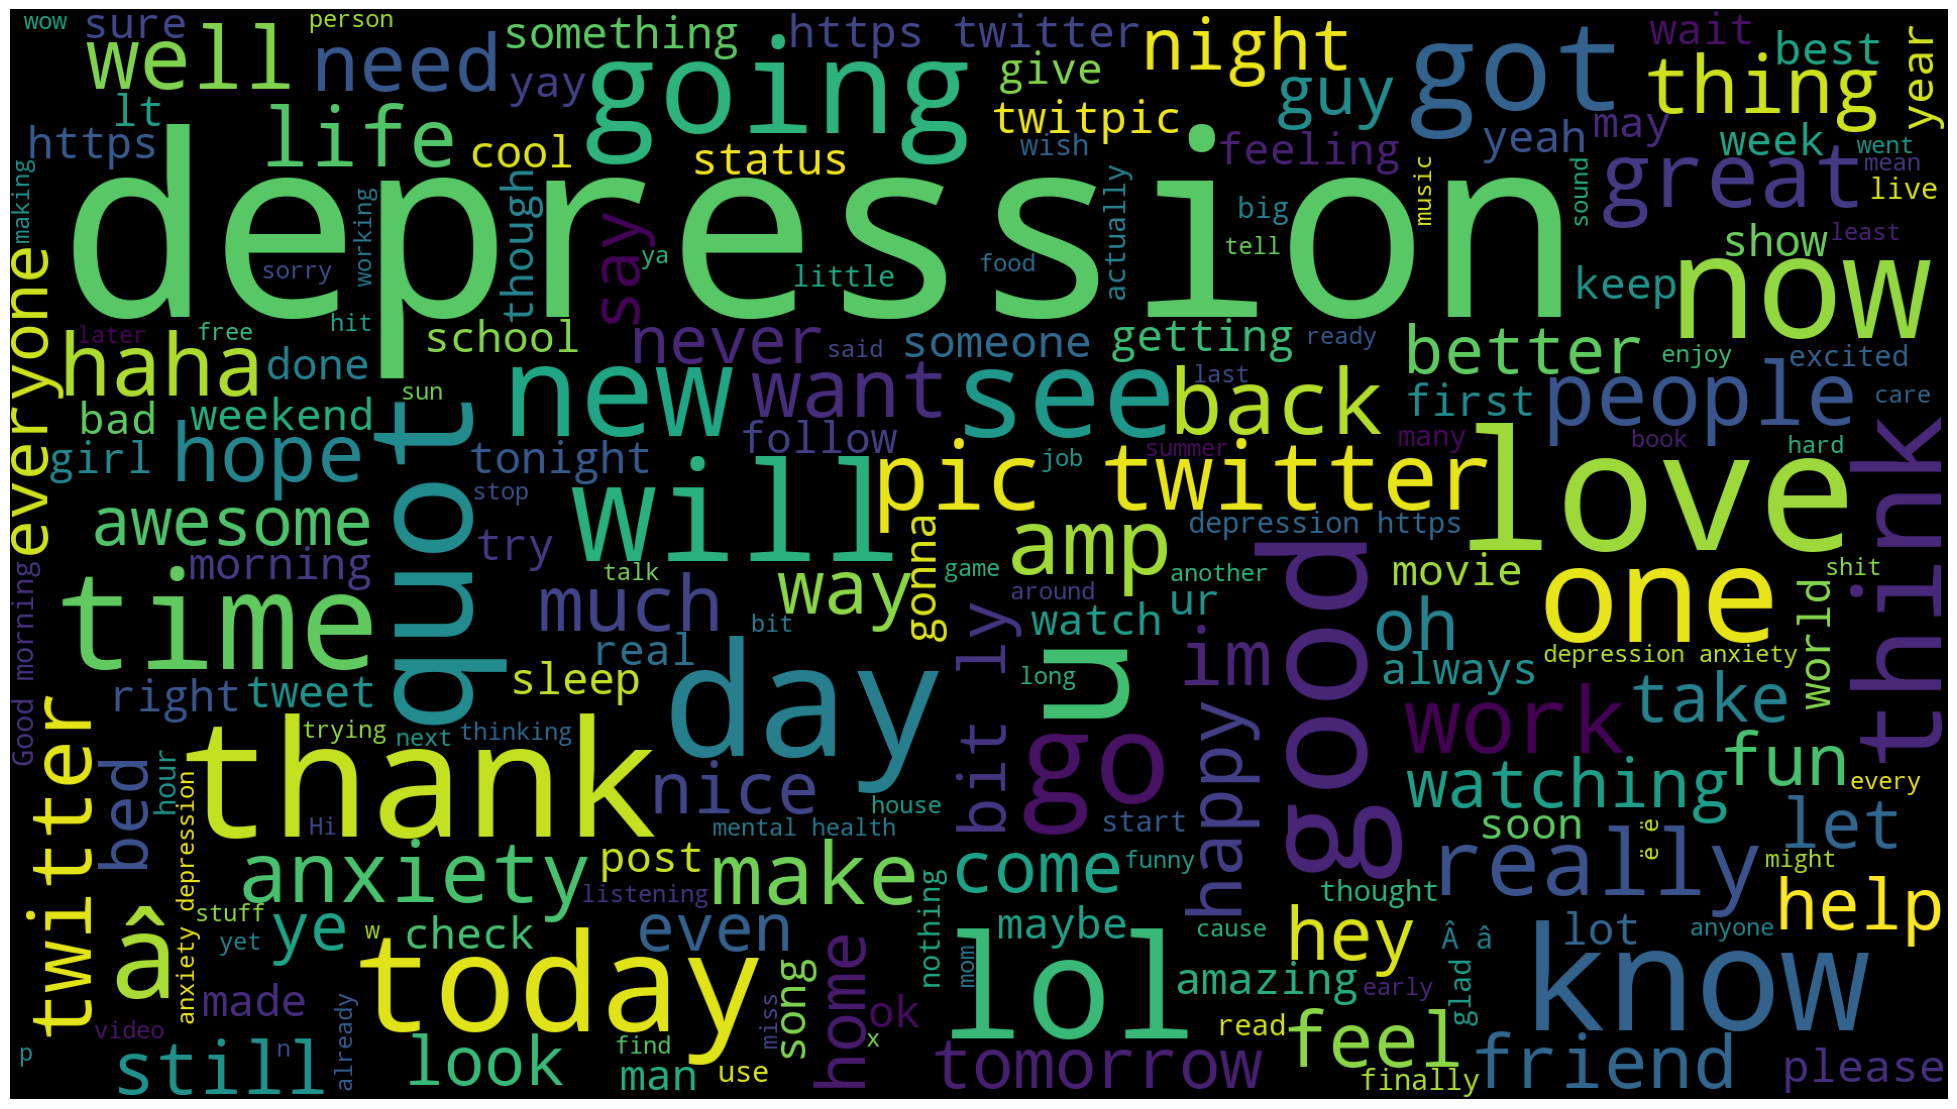

In [161]:
from wordcloud import WordCloud

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                     ).generate(" ".join(data['message to examine']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

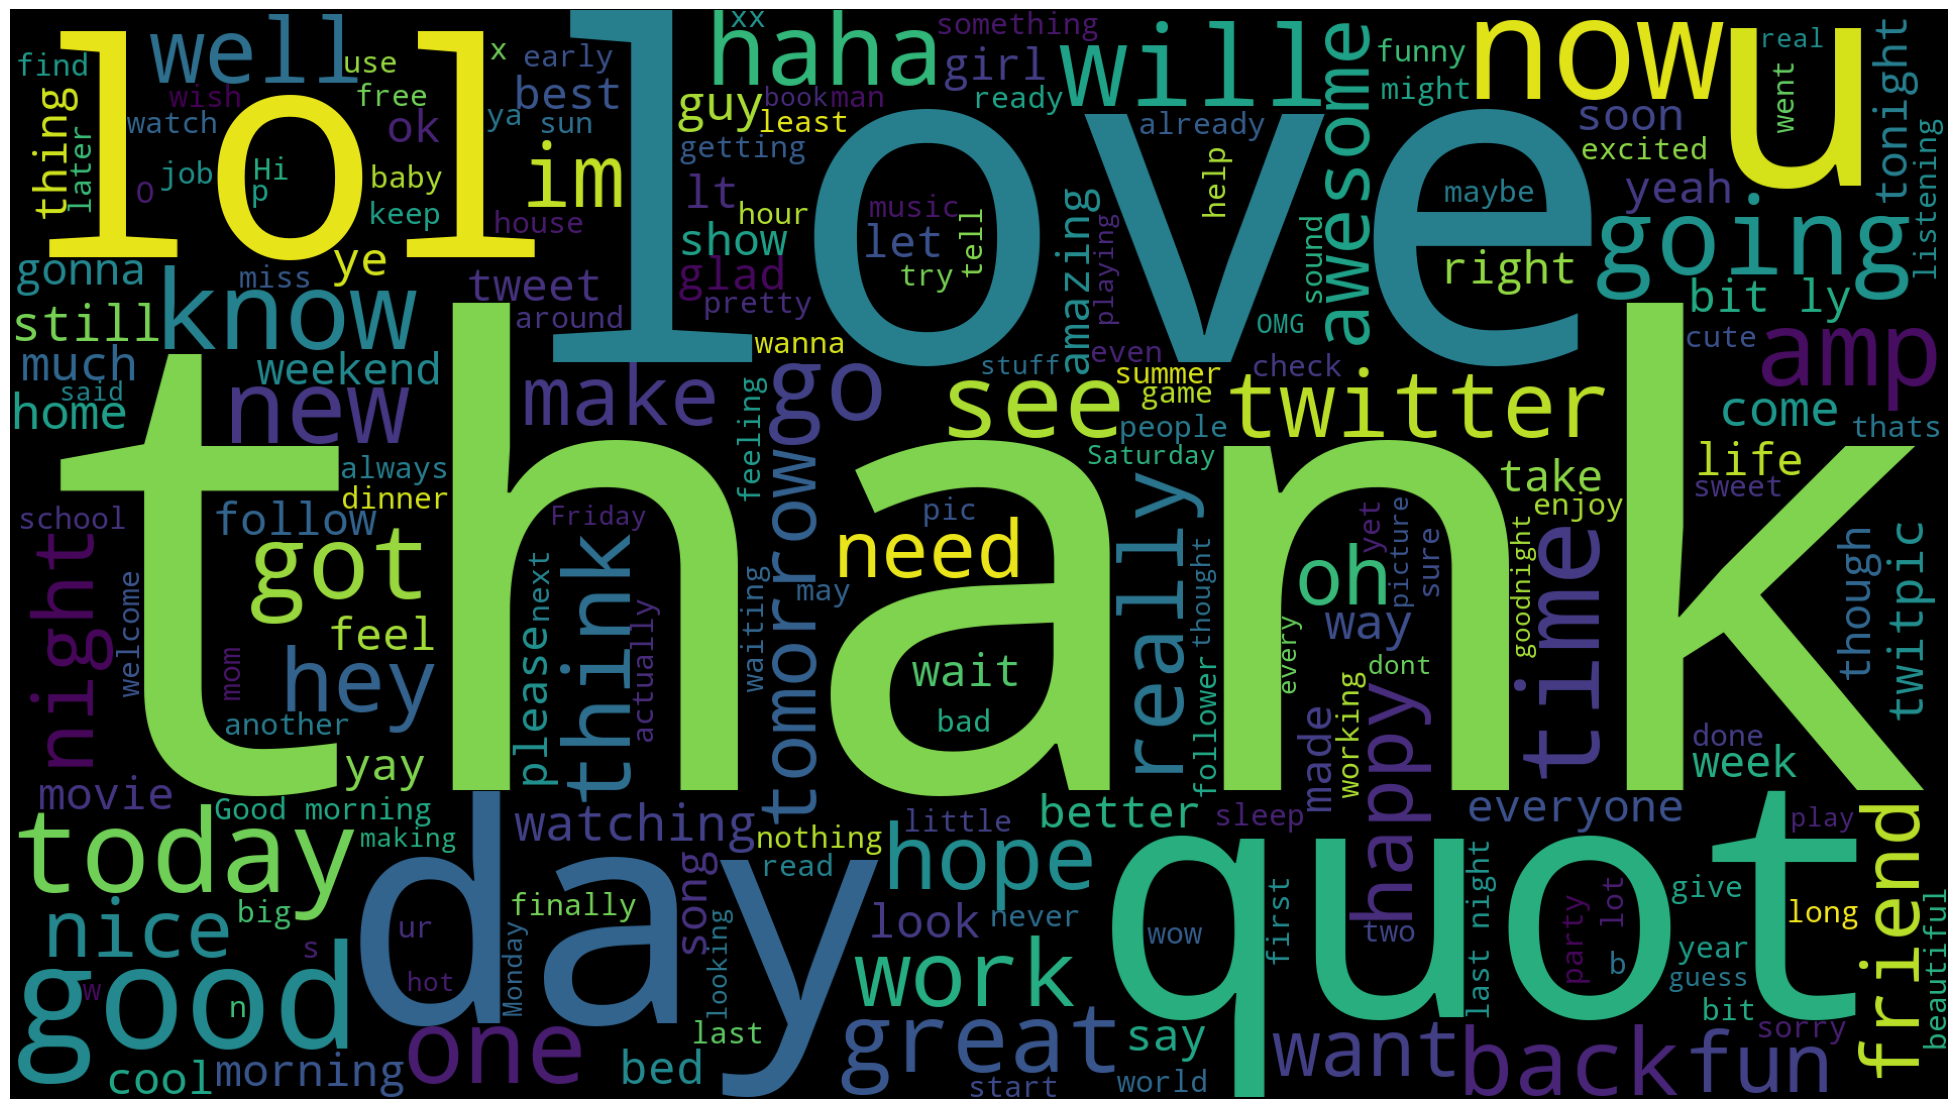

In [162]:
# Non Depression Words

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                     ).generate(" ".join(data[data['label (depression result)'] == 0]['message to examine']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

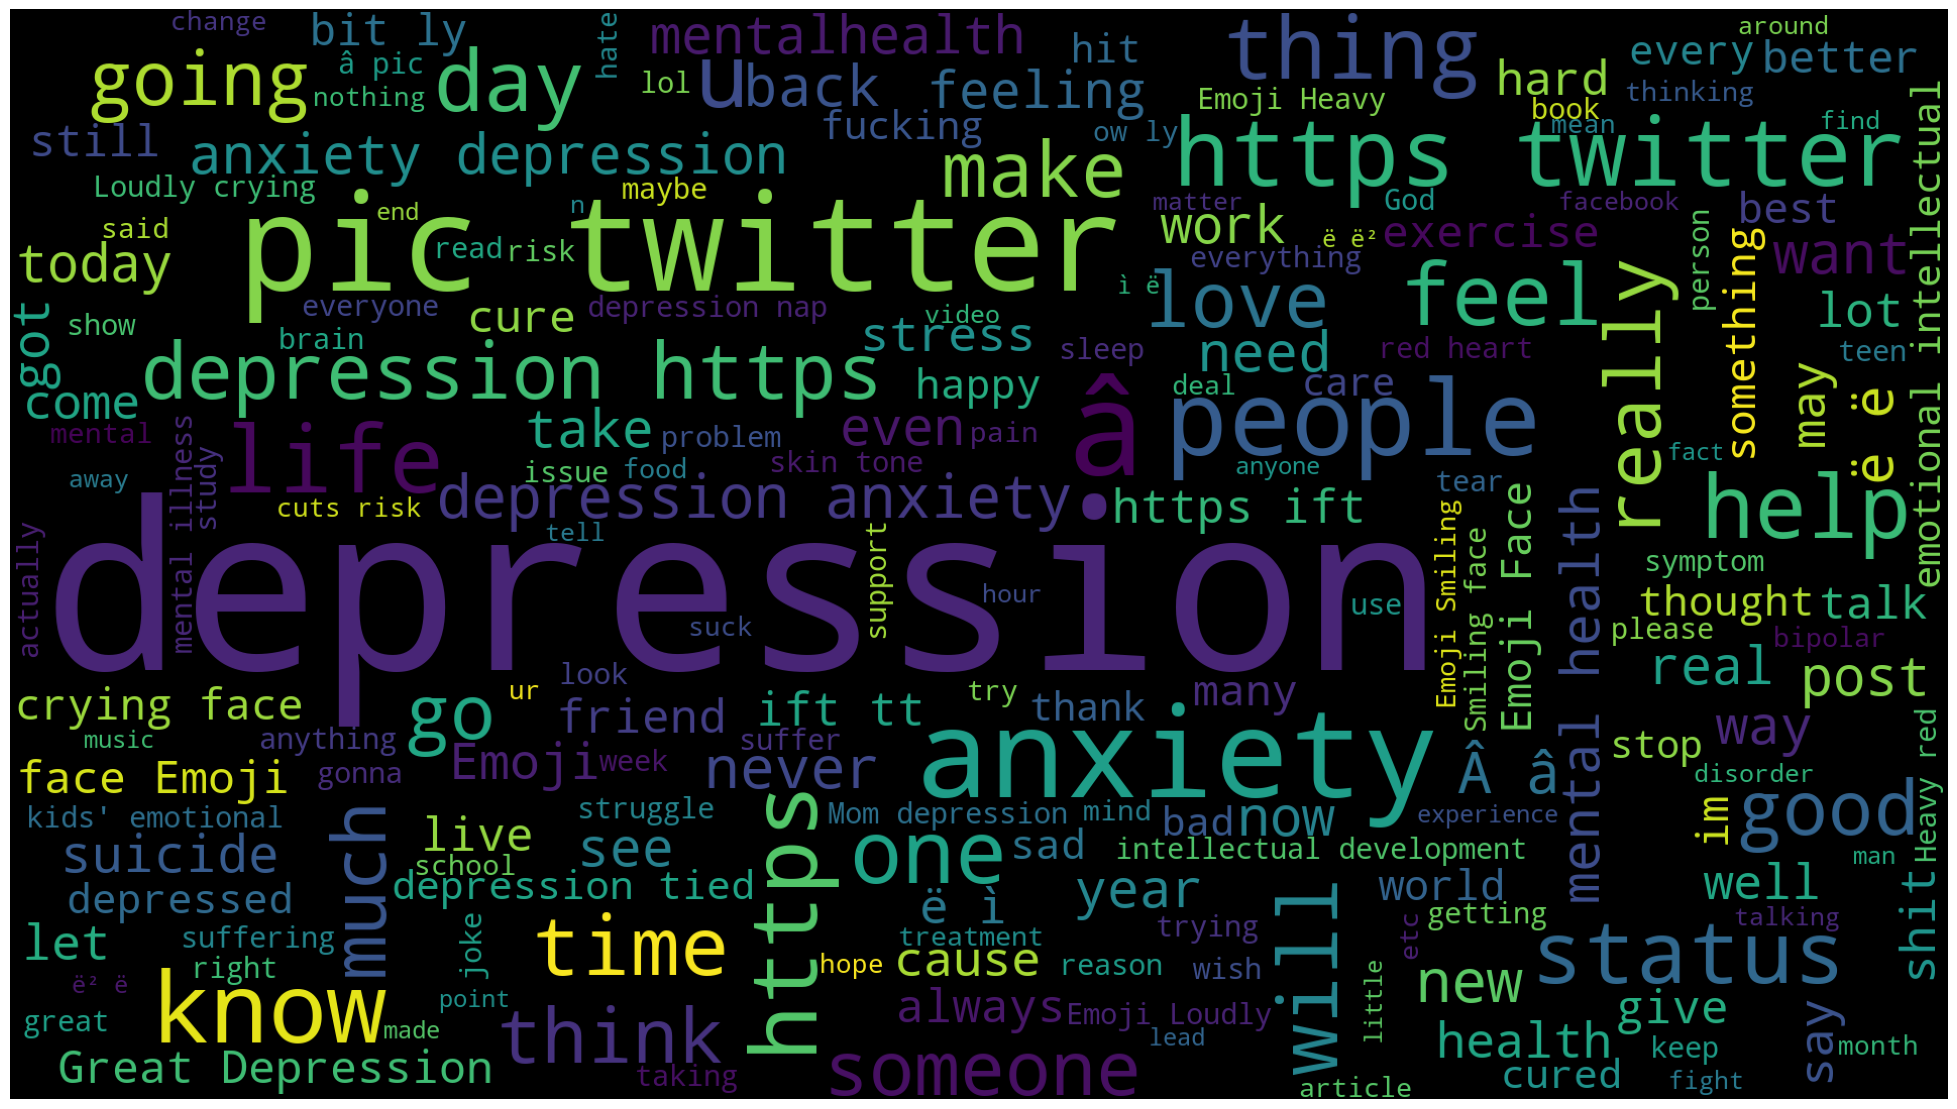

In [163]:
# Depression Words

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                     ).generate(" ".join(data[data['label (depression result)'] == 1]['message to examine']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#  Data Preprocessing

### Removing URL’s


In [164]:
# Removing URLs from the tweets
def remove_urls(text):
    url_pattern = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
    return url_pattern.sub(r'', text)

data['urlsRemoved'] = data['message to examine'].apply(remove_urls)
data.head()

Index                                 message to examine  \
0    106  just had a real good moment. i missssssssss hi...   
1    217         is reading manga  http://plurk.com/p/mzp1e   
2    220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3    288  @lapcat Need to send 'em to my accountant tomo...   
4    540      ADD ME ON MYSPACE!!!  myspace.com/LookThunder   

   label (depression result)  \
0                          0   
1                          0   
2                          0   
3                          0   
4                          0   

                                         urlsRemoved  
0  just had a real good moment. i missssssssss hi...  
1                                 is reading manga    
2                                 @comeagainjen  -    
3  @lapcat Need to send 'em to my accountant tomo...  
4                             ADD ME ON MYSPACE!!!

### Removing Emoji and Emoticons

In [165]:
# Removing Emoji and Emoticons
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"  # other miscellaneous symbols
                                  u"\U000024C2-\U0001F251"  # enclosed characters
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['emojiRemoved'] = data['urlsRemoved'].apply(remove_emoji)
data

Index                                 message to examine  \
0         106  just had a real good moment. i missssssssss hi...   
1         217         is reading manga  http://plurk.com/p/mzp1e   
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3         288  @lapcat Need to send 'em to my accountant tomo...   
4         540      ADD ME ON MYSPACE!!!  myspace.com/LookThunder   
...       ...                                                ...   
10308  802308  Many sufferers of depression aren't sad; they ...   
10309  802309  No Depression by G Herbo is my mood from now o...   
10310  802310  What do you do when depression succumbs the br...   
10311  802311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  802312  dont mistake a bad day with depression! everyo...   

       label (depression result)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
10308                          1   
10309                          1   
10310                          1   
10311                          1   
10312                          1   

                                             urlsRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                            emojiRemoved  
0      just had a real good moment. i missssssssss hi...  
1                                     is reading manga    
2                                     @comeagainjen  -    
3      @lapcat Need to send 'em to my accountant tomo...  
4                                 ADD ME ON MYSPACE!!!    
...                                                  ...  
10308  Many sufferers of depression aren't sad; they ...  
10309  No Depression by G Herbo is my mood from now o...  
10310  What do you do when depression succumbs the br...  
10311  Ketamine Nasal Spray Shows Promise Against Dep...  
10312  dont mistake a bad day with depression! everyo...  

[10313 rows x 5 columns]

### Handling ChatWords

In [166]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'message to examine' column
data['message to examine'] = data['message to examine'].apply(replace_chat_words)
data

Index                                 message to examine  \
0         106  just had a real good moment. i missssssssss hi...   
1         217          is reading manga http://plurk.com/p/mzp1e   
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3         288  @lapcat Need to send 'em to my accountant tomo...   
4         540       ADD ME ON MYSPACE!!! myspace.com/LookThunder   
...       ...                                                ...   
10308  802308  Many sufferers of depression aren't sad; they ...   
10309  802309  No Depression by G Herbo is my mood from now o...   
10310  802310  What do you do when depression succumbs the br...   
10311  802311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  802312  dont mistake a bad day with depression! everyo...   

       label (depression result)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
10308                          1   
10309                          1   
10310                          1   
10311                          1   
10312                          1   

                                             urlsRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                            emojiRemoved  
0      just had a real good moment. i missssssssss hi...  
1                                     is reading manga    
2                                     @comeagainjen  -    
3      @lapcat Need to send 'em to my accountant tomo...  
4                                 ADD ME ON MYSPACE!!!    
...                                                  ...  
10308  Many sufferers of depression aren't sad; they ...  
10309  No Depression by G Herbo is my mood from now o...  
10310  What do you do when depression succumbs the br...  
10311  Ketamine Nasal Spray Shows Promise Against Dep...  
10312  dont mistake a bad day with depression! everyo...  

[10313 rows x 5 columns]

### Removing Punctuations

In [167]:
# Match all non-alphanumeric and non-whitespace characters,
pattern = r"[^\w\s]"

data['punkt'] = data['emojiRemoved'].apply(lambda x: re.sub(pattern, " ", x))
data

Index                                 message to examine  \
0         106  just had a real good moment. i missssssssss hi...   
1         217          is reading manga http://plurk.com/p/mzp1e   
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3         288  @lapcat Need to send 'em to my accountant tomo...   
4         540       ADD ME ON MYSPACE!!! myspace.com/LookThunder   
...       ...                                                ...   
10308  802308  Many sufferers of depression aren't sad; they ...   
10309  802309  No Depression by G Herbo is my mood from now o...   
10310  802310  What do you do when depression succumbs the br...   
10311  802311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  802312  dont mistake a bad day with depression! everyo...   

       label (depression result)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
10308                          1   
10309                          1   
10310                          1   
10311                          1   
10312                          1   

                                             urlsRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                            emojiRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                                   punkt  
0      just had a real good moment  i missssssssss hi...  
1                                     is reading manga    
2                                      comeagainjen       
3       lapcat Need to send  em to my accountant tomo...  
4                                 ADD ME ON MYSPACE       
...                                                  ...  
10308  Many sufferers of depression aren t sad  they ...  
10309  No Depression by G Herbo is my mood from now o...  
10310  What do you do when depression succumbs the br...  
10311  Ketamine Nasal Spray Shows Promise Against Dep...  
10312  dont mistake a bad day with depression  everyo...  

[10313 rows x 6 columns]

### Removing Stop Words

In [168]:
STOPWORDS = set(stopwords.words('english'))

# Function to remove the stopwords
def stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

data['stopWord_Removed'] = data['punkt'].apply(stopwords)

data

Index                                 message to examine  \
0         106  just had a real good moment. i missssssssss hi...   
1         217          is reading manga http://plurk.com/p/mzp1e   
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3         288  @lapcat Need to send 'em to my accountant tomo...   
4         540       ADD ME ON MYSPACE!!! myspace.com/LookThunder   
...       ...                                                ...   
10308  802308  Many sufferers of depression aren't sad; they ...   
10309  802309  No Depression by G Herbo is my mood from now o...   
10310  802310  What do you do when depression succumbs the br...   
10311  802311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  802312  dont mistake a bad day with depression! everyo...   

       label (depression result)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
10308                          1   
10309                          1   
10310                          1   
10311                          1   
10312                          1   

                                             urlsRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                            emojiRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                                   punkt  \
0      just had a real good moment  i missssssssss hi...   
1                                     is reading manga     
2                                      comeagainjen        
3       lapcat Need to send  em to my accountant tomo...   
4                                 ADD ME ON MYSPACE        
...                                                  ...   
10308  Many sufferers of depression aren t sad  they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression  everyo...   

                                        stopWord_Removed  
0                     real good moment missssssssss much  
1                                          reading manga  
2                                           comeagainjen  
3      lapcat Need send em accountant tomorrow Oddly ...  
4                                      ADD ME ON MYSPACE  
...                                                  ...  
10308  Many sufferers depression sad feel nothing per...  
10309  No Depression G Herbo mood done stressing peop...  
10310  What depression succumbs brain makes feel like...  
10311

### Lemmatization

In [169]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet data
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatizeRows(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data['lemmatizedRows'] = data['stopWord_Removed'].apply(lemmatizeRows)

# Display the first few rows to verify
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/furkanpirinc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/furkanpirinc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Index                                 message to examine  \
0    106  just had a real good moment. i missssssssss hi...   
1    217          is reading manga http://plurk.com/p/mzp1e   
2    220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3    288  @lapcat Need to send 'em to my accountant tomo...   
4    540       ADD ME ON MYSPACE!!! myspace.com/LookThunder   

   label (depression result)  \
0                          0   
1                          0   
2                          0   
3                          0   
4                          0   

                                         urlsRemoved  \
0  just had a real good moment. i missssssssss hi...   
1                                 is reading manga     
2                                 @comeagainjen  -     
3  @lapcat Need to send 'em to my accountant tomo...   
4                             ADD ME ON MYSPACE!!!     

                                        emojiRemoved  \
0  just had a real good moment. i missssssssss hi...   
1                                 is reading manga     
2                                 @comeagainjen  -     
3  @lapcat Need to send 'em to my accountant tomo...   
4                             ADD ME ON MYSPACE!!!     

                                               punkt  \
0  just had a real good moment  i missssssssss hi...   
1                                 is reading manga     
2                                  comeagainjen        
3   lapcat Need to send  em to my accountant tomo...   
4                             ADD ME ON MYSPACE        

                                    stopWord_Removed  \
0                 real good moment missssssssss much   
1                                      reading manga   
2                                       comeagainjen   
3  lapcat Need send em accountant tomorrow Oddly ...   
4                                  ADD ME ON MYSPACE   

                                      lemmatizedRows  
0                         real good moment miss much  
1                                      reading manga  
2                                       comeagainjen  
3  lapcat Need send em accountant tomorrow Oddly ...  
4                                  ADD ME ON MYSPACE

### Stemming

In [170]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemRows(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

data['stemmedRows'] = data['lemmatizedRows'].apply(stemRows)

data

Index                                 message to examine  \
0         106  just had a real good moment. i missssssssss hi...   
1         217          is reading manga http://plurk.com/p/mzp1e   
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3         288  @lapcat Need to send 'em to my accountant tomo...   
4         540       ADD ME ON MYSPACE!!! myspace.com/LookThunder   
...       ...                                                ...   
10308  802308  Many sufferers of depression aren't sad; they ...   
10309  802309  No Depression by G Herbo is my mood from now o...   
10310  802310  What do you do when depression succumbs the br...   
10311  802311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  802312  dont mistake a bad day with depression! everyo...   

       label (depression result)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
10308                          1   
10309                          1   
10310                          1   
10311                          1   
10312                          1   

                                             urlsRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                            emojiRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                                   punkt  \
0      just had a real good moment  i missssssssss hi...   
1                                     is reading manga     
2                                      comeagainjen        
3       lapcat Need to send  em to my accountant tomo...   
4                                 ADD ME ON MYSPACE        
...                                                  ...   
10308  Many sufferers of depression aren t sad  they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression  everyo...   

                                        stopWord_Removed  \
0                     real good moment missssssssss much   
1                                          reading manga   
2                                           comeagainjen   
3      lapcat Need send em accountant tomorrow Oddly ...   
4                                      ADD ME ON MYSPACE   
...                                                  ...   
10308  Many sufferers depression sad feel nothing per...   
10309  No Depression G Herbo mood done stressing peop...   
10310  What depression succumbs brain makes feel like..

### Tokens Cleaning

In [171]:
def cleanData(text):
    ReapeatTokensRm =  " ".join( [ re.sub(r'(\\w)\\1{2,}', r'\\1', word) for word in text.split()] )  # Remove repeating characters from tokens
    digitTokensRm =  " ".join( [ word for word in ReapeatTokensRm.split() if not re.search(r'\\d', word) ] ) # Remove tokens containing digits
    underscoreTokensRm =  " ".join( [ word for word in digitTokensRm.split() if not re.search(r'_|\\w*_\\w*', word) ] ) # Remove tokens containing underscore
    specialTokensRm =  " ".join( [ word for word in underscoreTokensRm.split() if not re.search(r'[^a-zA-Z0-9\\s]', word) ] ) # Remove tokens containing Special Characters
    return " ".join( [ word for word in specialTokensRm.split() if len(word) > 2 ] )  # Remove tokens less than 2 characters

data['cleanTokens'] = data['stemmedRows'].apply(cleanData)
data


Index                                 message to examine  \
0         106  just had a real good moment. i missssssssss hi...   
1         217          is reading manga http://plurk.com/p/mzp1e   
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3         288  @lapcat Need to send 'em to my accountant tomo...   
4         540       ADD ME ON MYSPACE!!! myspace.com/LookThunder   
...       ...                                                ...   
10308  802308  Many sufferers of depression aren't sad; they ...   
10309  802309  No Depression by G Herbo is my mood from now o...   
10310  802310  What do you do when depression succumbs the br...   
10311  802311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  802312  dont mistake a bad day with depression! everyo...   

       label (depression result)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
10308                          1   
10309                          1   
10310                          1   
10311                          1   
10312                          1   

                                             urlsRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                            emojiRemoved  \
0      just had a real good moment. i missssssssss hi...   
1                                     is reading manga     
2                                     @comeagainjen  -     
3      @lapcat Need to send 'em to my accountant tomo...   
4                                 ADD ME ON MYSPACE!!!     
...                                                  ...   
10308  Many sufferers of depression aren't sad; they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression! everyo...   

                                                   punkt  \
0      just had a real good moment  i missssssssss hi...   
1                                     is reading manga     
2                                      comeagainjen        
3       lapcat Need to send  em to my accountant tomo...   
4                                 ADD ME ON MYSPACE        
...                                                  ...   
10308  Many sufferers of depression aren t sad  they ...   
10309  No Depression by G Herbo is my mood from now o...   
10310  What do you do when depression succumbs the br...   
10311  Ketamine Nasal Spray Shows Promise Against Dep...   
10312  dont mistake a bad day with depression  everyo...   

                                        stopWord_Removed  \
0                     real good moment missssssssss much   
1                                          reading manga   
2                                           comeagainjen   
3      lapcat Need send em accountant tomorrow Oddly ...   
4                                      ADD ME ON MYSPACE   
...                                                  ...   
10308  Many sufferers depression sad feel nothing per...   
10309  No Depression G Herbo mood done stressing peop...   
10310  What depression succumbs brain makes feel like..

### TF-IDF Vectorization

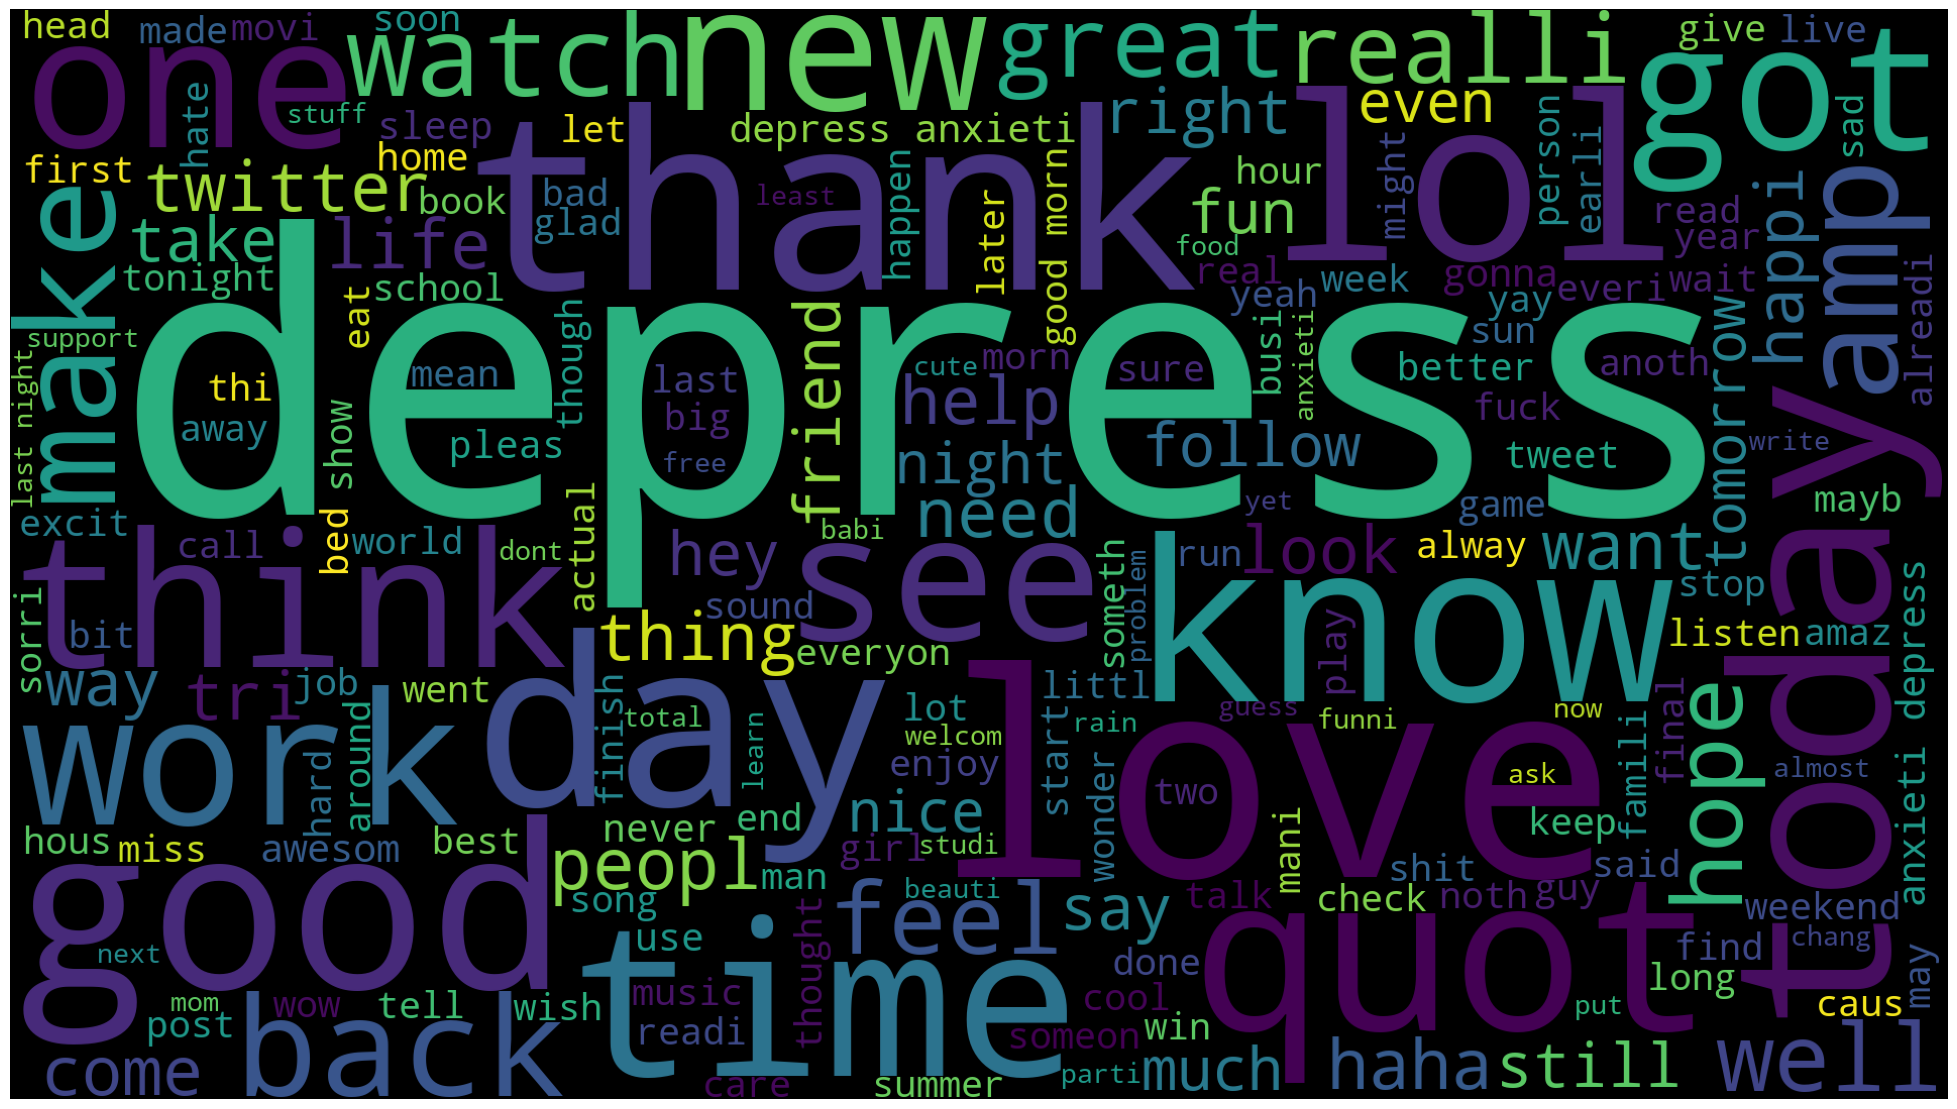

In [172]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                     ).generate(" ".join(data['cleanTokens']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

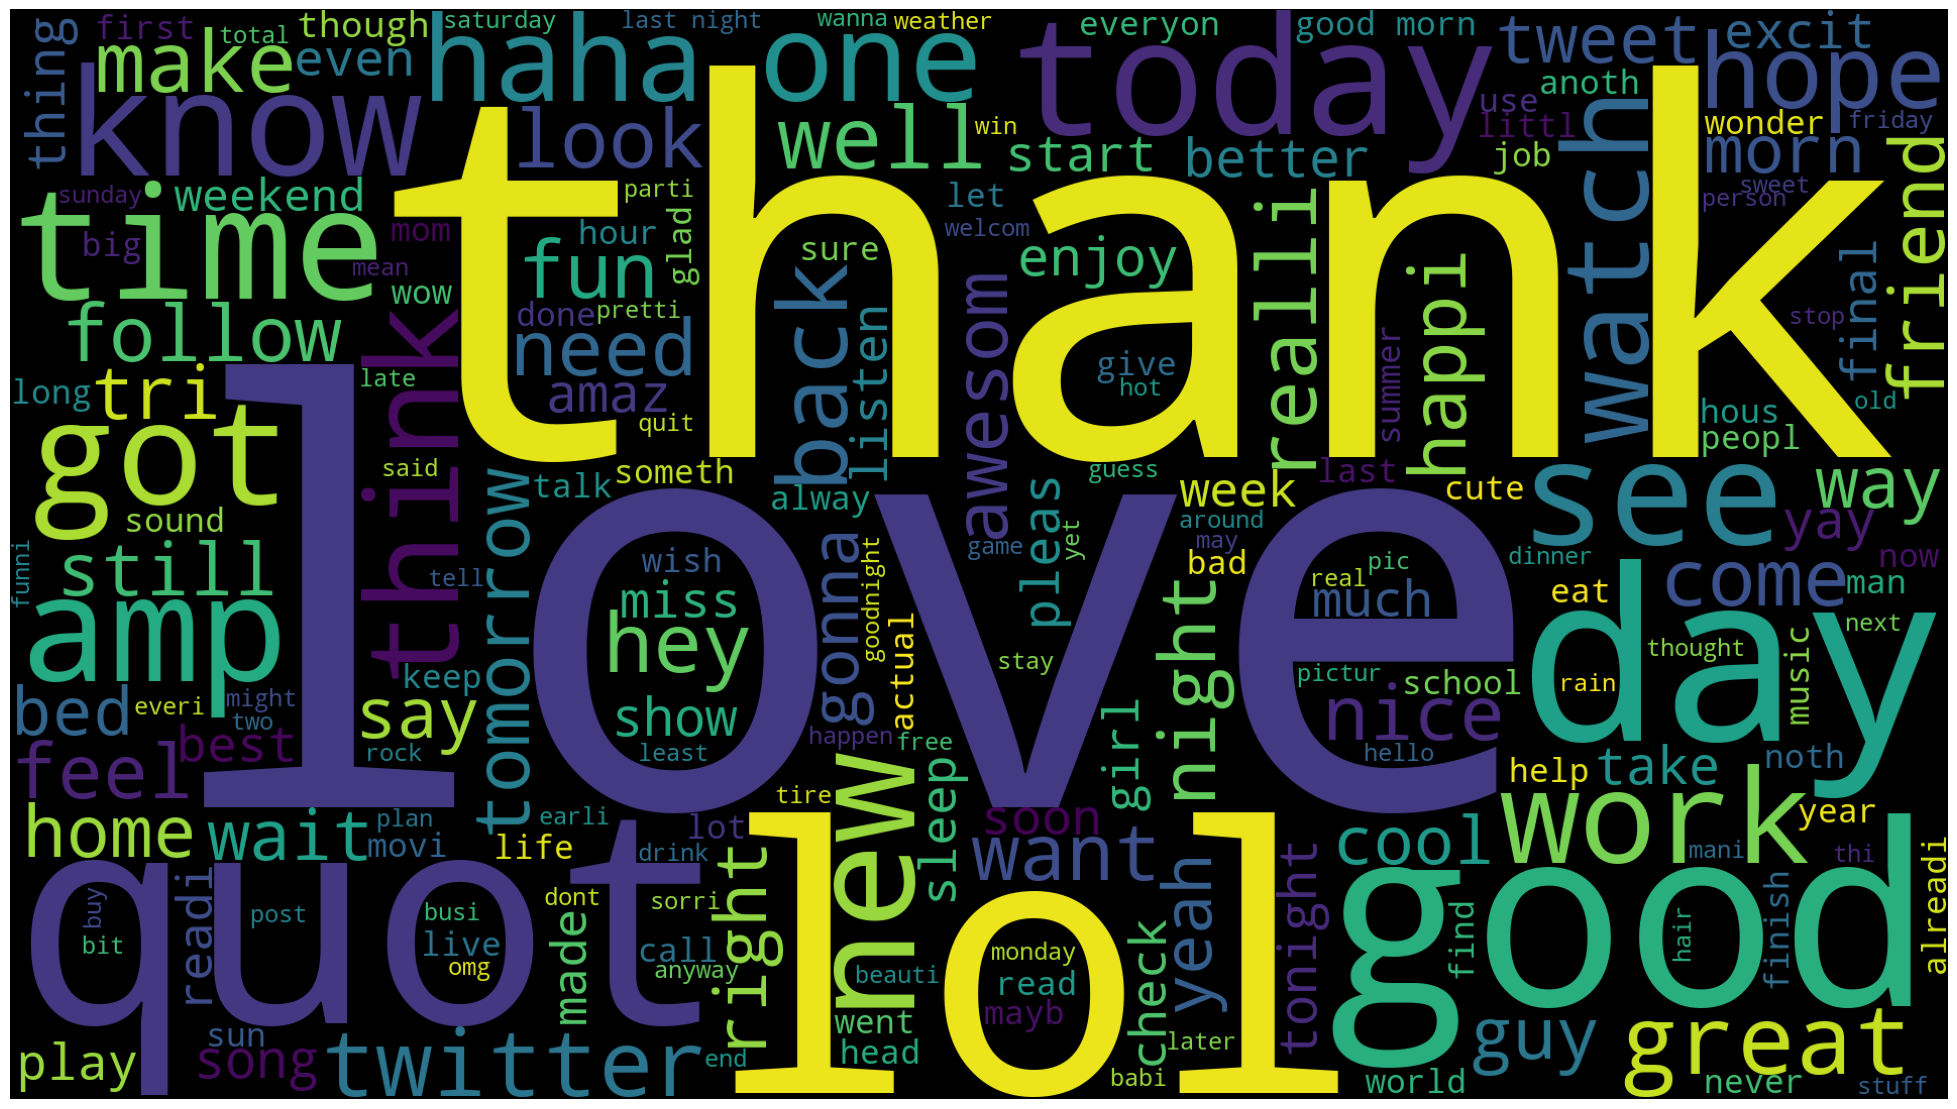

In [173]:
# Non Depression Words

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                     ).generate(" ".join(data[data['label (depression result)'] == 0]['cleanTokens']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

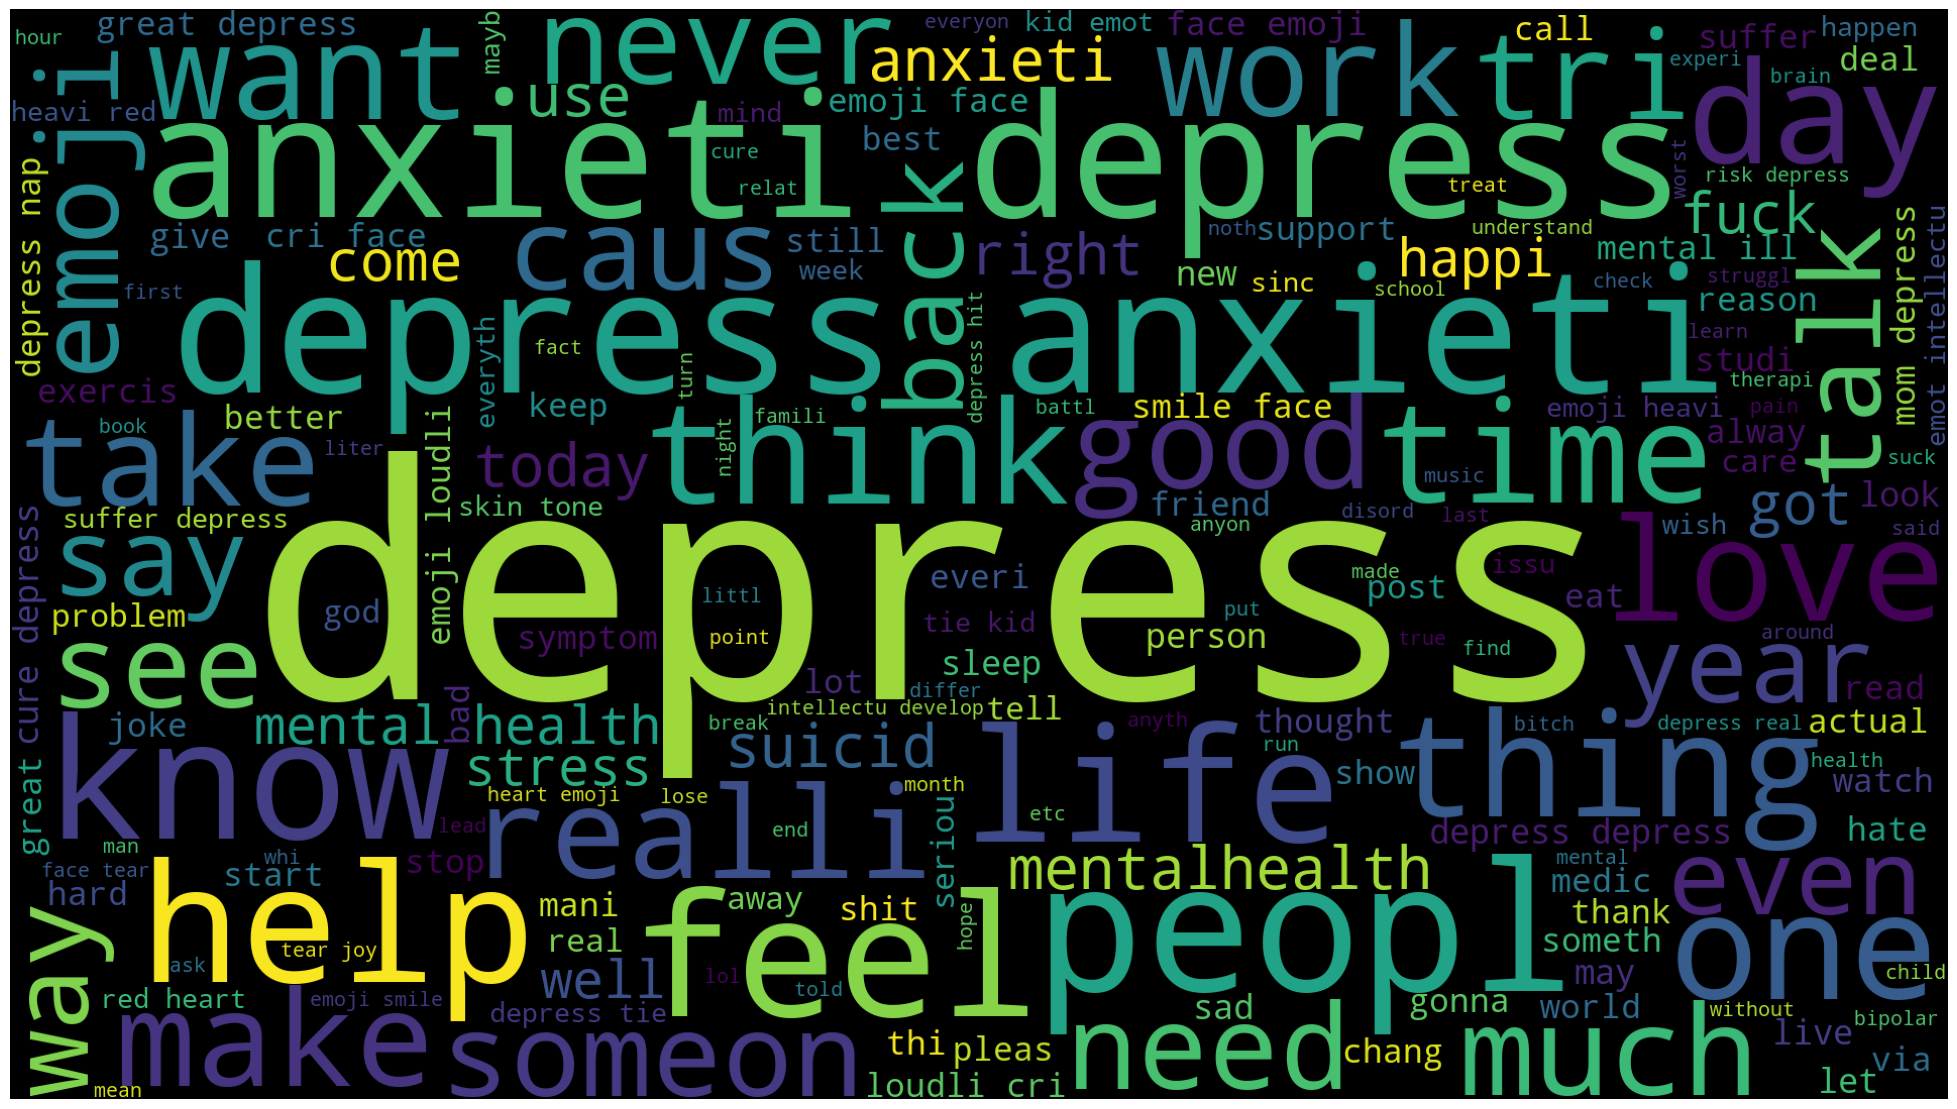

In [174]:
# Depression Words

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                     ).generate(" ".join(data[data['label (depression result)'] == 1]['cleanTokens']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'cleanTokens' column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleanTokens'])

# Get feature names (words)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)

# Display the first few rows of the DataFrame
print(tfidf_df.head())

   000  007peter  00am  00pm  02am  0628  07958938647  09casper  0beck  100  \
0  0.0       0.0   0.0   0.0   0.0   0.0          0.0       0.0    0.0  0.0   
1  0.0       0.0   0.0   0.0   0.0   0.0          0.0       0.0    0.0  0.0   
2  0.0       0.0   0.0   0.0   0.0   0.0          0.0       0.0    0.0  0.0   
3  0.0       0.0   0.0   0.0   0.0   0.0          0.0       0.0    0.0  0.0   
4  0.0       0.0   0.0   0.0   0.0   0.0          0.0       0.0    0.0  0.0   

   ...  zoot  zooyork  zpush  ztnewetnorb  zumba  zzz  zzzz  zzzzz  \
0  ...   0.0      0.0    0.0          0.0    0.0  0.0   0.0    0.0   
1  ...   0.0      0.0    0.0          0.0    0.0  0.0   0.0    0.0   
2  ...   0.0      0.0    0.0          0.0    0.0  0.0   0.0    0.0   
3  ...   0.0      0.0    0.0          0.0    0.0  0.0   0.0    0.0   
4  ...   0.0      0.0    0.0          0.0    0.0  0.0   0.0    0.0   

   zzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz  
0         0.0                                  0.0 

In [176]:
# Display the shape of the TF-IDF matrix
tfidf_matrix.shape

(10313, 16305)

In [177]:
tfidf_features[:1000]

array(['000', '007peter', '00am', '00pm', '02am', '0628', '07958938647',
       '09casper', '0beck', '100', '1000', '10000', '101', '1011',
       '106andpark', '109', '10am', '10pm', '10th', '10x',
       '10yearsofenema', '10yr', '110', '1200', '123', '12mp', '12pm',
       '12th', '130', '13flat', '13th', '140', '14554550', '149', '150',
       '151', '152', '1545', '15hr', '15mab', '15th', '160', '16th',
       '175mph', '17th', '180', '182', '187', '18percentgrey', '18th',
       '18yr', '190lb', '1920', '1929', '1930', '1932', '1938', '1943',
       '1979', '1982', '1983', '1994', '1996', '1997', '1998', '1999',
       '19hr', '19th', '1am', '1bramant', '1cappleg', '1flyharmoni',
       '1in', '1jaredpadalecki', '1omarion', '1pm', '1st', '1stlady',
       '1stladyay', '1sweetwhirl', '1tb', '1txsage1957', '1up',
       '1winedud', '1xq', '200', '2000', '2001', '2005', '2006', '2007',
       '2008', '2009', '200gb', '2010', '2012', '2013', '2014', '2015',
       '2016', '2017', '20

### Splitting Data

In [178]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test ,y_train ,y_test = train_test_split(tfidf_matrix, data['label (depression result)'], test_size=0.2,
                                                    stratify= data['label (depression result)']  , random_state=0)

In [179]:
# Display shapes of the training and testing sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8250, 16305), (8250,), (2063, 16305), (2063,))

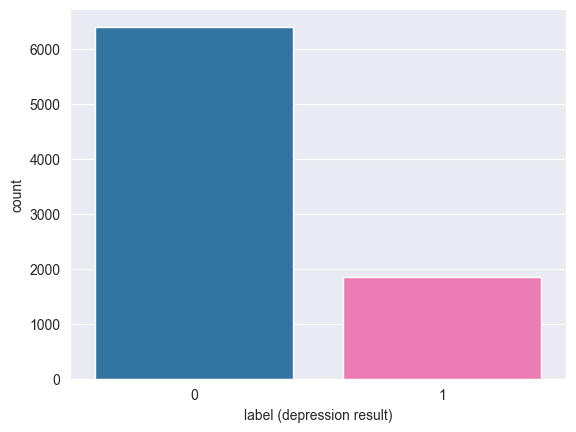

In [180]:
# Create a count plot to visualize the distribution of labels in the training set
custom_palette = ["#1f77b4", "#ff69b4"]  # Blue and Pink

sns.countplot(x=y_train, palette=custom_palette)
plt.show()

In [181]:
from sklearn.utils import compute_class_weight

# Compute class weights to handle class imbalance
classWeights = compute_class_weight("balanced", classes = np.unique(data['label (depression result)']),
                                     y = data['label (depression result)'])
classWeights = dict(zip(np.unique(np.unique(data['label (depression result)'])), classWeights))

print(classWeights)

{0: 0.6445625, 1: 2.229355814958928}


### Evaluating Models

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

In [183]:
# Initialize classifiers
lr = LogisticRegression(class_weight=classWeights, random_state=0)
nb = MultinomialNB()
dt = DecisionTreeClassifier(class_weight=classWeights, random_state=0)
rf = RandomForestClassifier(class_weight=classWeights, random_state=0)
svc = LinearSVC(class_weight=classWeights, random_state=0)
lgbm = lgb.LGBMClassifier(class_weight=classWeights, random_state=0)
catboost = CatBoostClassifier(class_weights=classWeights, random_state=0, verbose=0)
nnn = MLPClassifier(random_state=0)

In [184]:
# List of models and their names
models = [lr, nb, dt, rf, svc, lgbm, catboost, nnn]
model_names = ["Logistic Regression", "Naive Bayes", "Decision Trees", "Random Forests", "Support Vector", "LightGBM", "CatBoost", "Neural Network"]

# Train all models
for model in models:
    model.fit(X_train.toarray(), y_train)

[LightGBM] [Info] Number of positive: 1850, number of negative: 6400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13279
[LightGBM] [Info] Number of data points in the train set: 8250, number of used features: 570
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499946 -> initscore=-0.000216
[LightGBM] [Info] Start training from score -0.000216


In [185]:
# Calculate training accuracy scores
train_scores = [model.score(X_train.toarray(), y_train) for model in models]


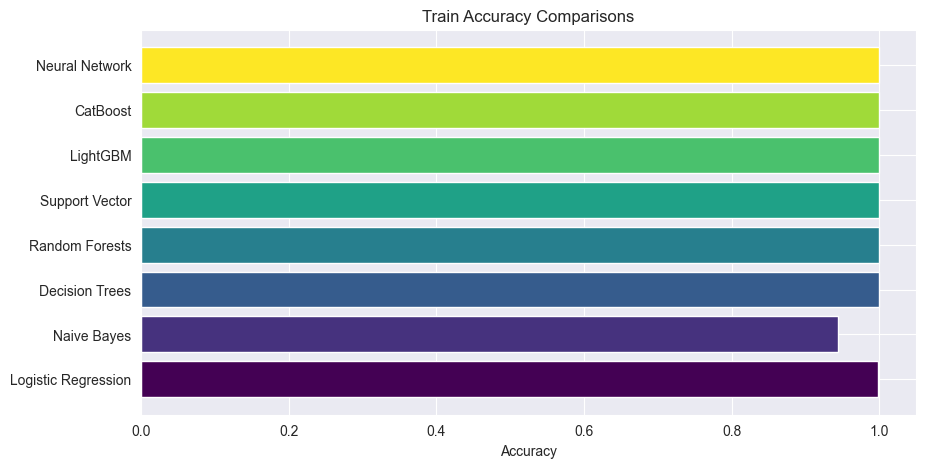

In [186]:
# Plot training accuracy scores
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
plt.figure(figsize=(10, 5))
plt.barh(model_names, width=train_scores, color=colors)
plt.title("Train Accuracy Comparisons")
plt.xlabel("Accuracy")
plt.show()

Logistic Regression Train Accuracy score is : 99.77%
Naive Bayes Train Accuracy score is : 94.38%
Decision Trees Train Accuracy score is : 99.98%
Random Forests Train Accuracy score is : 99.98%
Support Vector Train Accuracy score is : 99.98%
LightGBM Train Accuracy score is : 99.94%
CatBoost Train Accuracy score is : 99.98%
Neural Network Train Accuracy score is : 99.98%


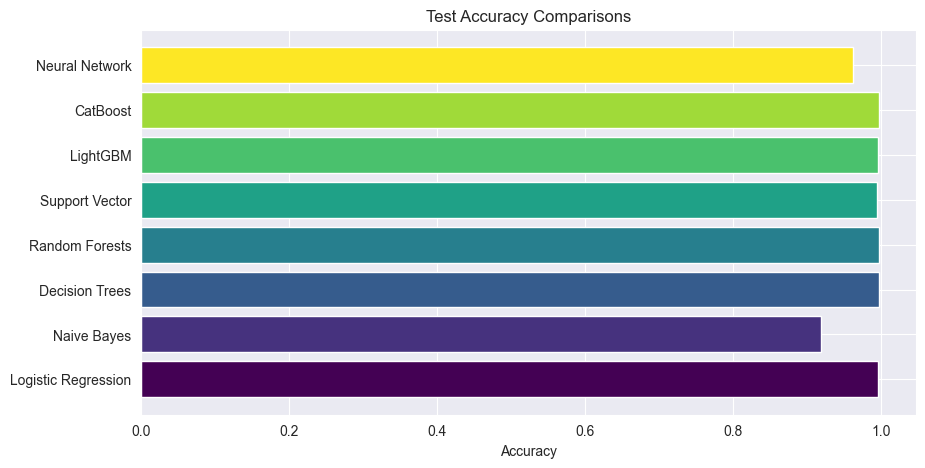

Logistic Regression Test Accuracy score is : 99.52%
Naive Bayes Test Accuracy score is : 91.86%
Decision Trees Test Accuracy score is : 99.71%
Random Forests Test Accuracy score is : 99.71%
Support Vector Test Accuracy score is : 99.47%
LightGBM Test Accuracy score is : 99.61%
CatBoost Test Accuracy score is : 99.66%
Neural Network Test Accuracy score is : 96.17%


In [187]:
# Print training accuracy scores
for name, score in zip(model_names, train_scores):
    print(f'{name} Train Accuracy score is : {round(score * 100, 2)}%')

# Calculate test accuracy scores
test_scores = [model.score(X_test.toarray(), y_test) for model in models]

# Plot test accuracy scores
plt.figure(figsize=(10, 5))
plt.barh(model_names, width=test_scores, color=colors)
plt.title("Test Accuracy Comparisons")
plt.xlabel("Accuracy")
plt.show()

# Print test accuracy scores
for name, score in zip(model_names, test_scores):
    print(f'{name} Test Accuracy score is : {round(score * 100, 2)}%')

In [188]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

# Get predictions from each model
lrPreds = lr.predict(X_test.toarray())
nbPreds = nb.predict(X_test.toarray())
dtPreds = dt.predict(X_test.toarray())
rfPreds = rf.predict(X_test.toarray())
svcPreds = svc.predict(X_test.toarray())
lgbmPreds = lgbm.predict(X_test.toarray())
catboostPreds = catboost.predict(X_test.toarray())
nnnPreds = nnn.predict(X_test.toarray())

In [189]:
# Calculate ROC AUC scores for each model
lrScore = roc_auc_score(y_test, lrPreds)
nbScore = roc_auc_score(y_test, nbPreds)
dtScore = roc_auc_score(y_test, dtPreds)
rfScore = roc_auc_score(y_test, rfPreds)
svcScore = roc_auc_score(y_test, svcPreds)
lgbmScore = roc_auc_score(y_test, lgbmPreds)
catboostScore = roc_auc_score(y_test, catboostPreds)
nnnScore = roc_auc_score(y_test, nnnPreds)

In [190]:
# List of model names and their ROC AUC scores
model_names = ["Logistic Regression", "Naive Bayes", "Decision Trees", "Random Forests", "Support Vector", "LightGBM", "CatBoost", "Neural Network"]
roc_auc_scores = [lrScore, nbScore, dtScore, rfScore, svcScore, lgbmScore, catboostScore, nnnScore]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

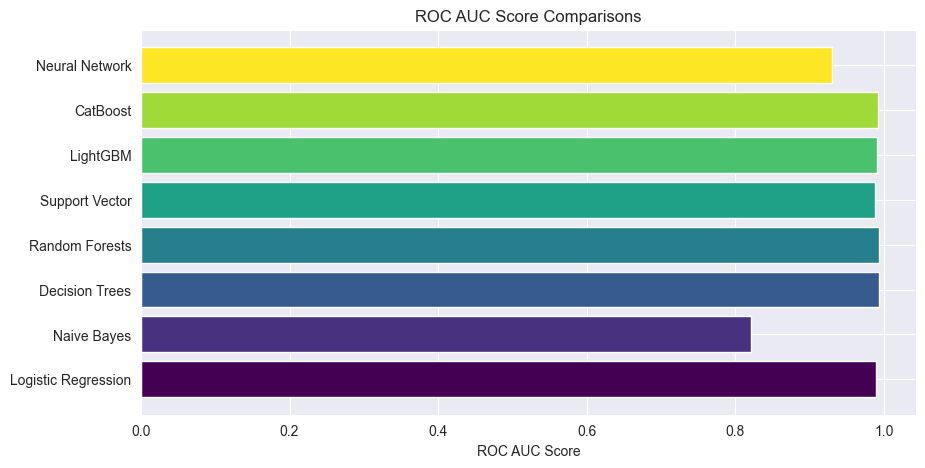

In [191]:
# Plot ROC AUC scores
plt.figure(figsize=(10, 5))
plt.barh(model_names, width=roc_auc_scores, color=colors)
plt.xlabel("ROC AUC Score")
plt.title("ROC AUC Score Comparisons")
plt.show()

In [192]:
# Print ROC AUC scores
for name, score in zip(model_names, roc_auc_scores):
    print(f'{name} Test ROC AUC Score is : {round(score * 100, 2)}%')

Logistic Regression Test ROC AUC Score is : 98.92%
Naive Bayes Test ROC AUC Score is : 82.16%
Decision Trees Test ROC AUC Score is : 99.35%
Random Forests Test ROC AUC Score is : 99.35%
Support Vector Test ROC AUC Score is : 98.81%
LightGBM Test ROC AUC Score is : 99.14%
CatBoost Test ROC AUC Score is : 99.24%
Neural Network Test ROC AUC Score is : 93.0%


In [193]:
# Select top 3 models based on ROC AUC scores
sorted_roc_auc_scores = sorted(zip(model_names, roc_auc_scores), key=lambda x: x[1], reverse=True)[:3]
best_models = [model for model, score in sorted_roc_auc_scores]
best_scores = [score for model, score in sorted_roc_auc_scores]

In [194]:
# Get predictions for the top 3 models
best_predictions = {
    "Decision Trees": dtPreds,
    "Random Forests": rfPreds,
    "LightGBM": lgbmPreds
}

In [195]:
# Print ROC AUC scores of the top 3 models
for model, score in sorted_roc_auc_scores:
    print(f'{model} Test ROC AUC Score is : {round(score * 100, 2)}%')

Decision Trees Test ROC AUC Score is : 99.35%
Random Forests Test ROC AUC Score is : 99.35%
CatBoost Test ROC AUC Score is : 99.24%


In [196]:
# Function to create confusion matrix
def makeCM_Matrix(cm_matrix, title):
    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cm_matrix.flatten() / np.sum(cm_matrix)]
    labels = [f'{v1}\n{v2} ({v3})' for v1, v2, v3 in zip(group_names, cm_matrix.flatten(), group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm_matrix, annot=labels, fmt='', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title(f"{title} Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

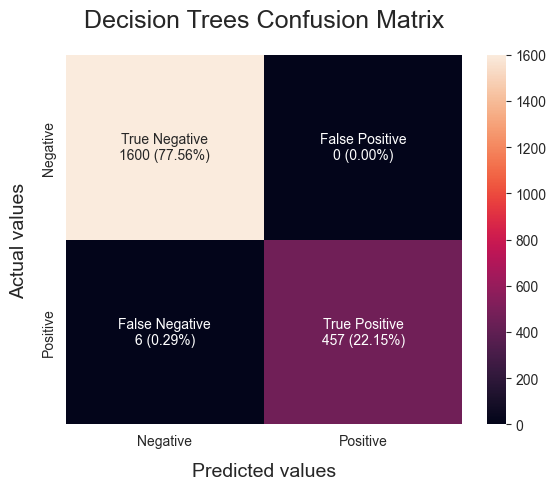

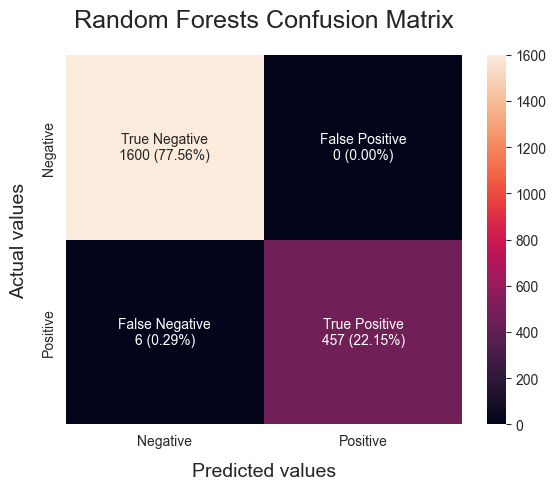

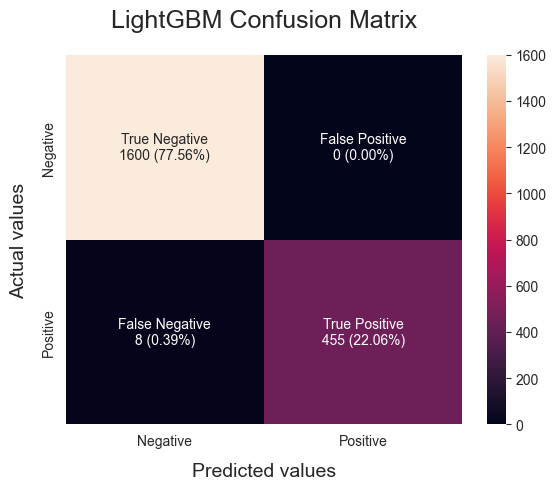

In [197]:
# Loop through the best predictions and create confusion matrices
for name, preds in best_predictions.items():
    makeCM_Matrix(confusion_matrix(y_test, preds), name)

In [198]:
# Loop through the best predictions and print classification reports
for name, preds in best_predictions.items():
    print(f'{name} Classification Report:\n', classification_report(y_test, preds, target_names=['No', 'Yes']))

Decision Trees Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00      1600
         Yes       1.00      0.99      0.99       463

    accuracy                           1.00      2063
   macro avg       1.00      0.99      1.00      2063
weighted avg       1.00      1.00      1.00      2063

Random Forests Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00      1600
         Yes       1.00      0.99      0.99       463

    accuracy                           1.00      2063
   macro avg       1.00      0.99      1.00      2063
weighted avg       1.00      1.00      1.00      2063

LightGBM Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00      1600
         Yes       1.00      0.98      0.99       463

    accuracy                           1.00      2063
   macro avg     